In [5]:
import torch
from torch import nn
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torchmetrics
import re
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data reading and creation of large df

In [6]:
blind_path = "../data/blind.fasta.txt"
cyto_path = "../data/cyto.fasta.txt"
mito_path = "../data/mito.fasta.txt"
nucleus_path = "../data/nucleus.fasta.txt"
other_path = "../data/other.fasta.txt"
secreted_path = "../data/secreted.fasta.txt"

In [7]:
def read_fasta(file):
    """
    This function takes an unstructured fasta file and outputs a dictionary of the sequences
    Input: - fasta file
    Output: - dict with keys (sequence header) and values (sequence)
    """
    sequences = {}
    with open(file, 'r') as f:
        header = ""
        sequence = ""
        for line in f:
            #in a fasta file the first character is a > sign
            if line[0] == ">":
                if header:
                    sequences[header] = sequence
                header = line[1:].strip()
                sequence = ""
            else:
                sequence += line.strip()
        sequences[header] = sequence
    return sequences

In [35]:
# This creates the dictionary of sequences for each location
blind_sequences = read_fasta(blind_path)
cyto_sequences = read_fasta(cyto_path)
mito_sequences = read_fasta(mito_path)
nucleus_sequences = read_fasta(nucleus_path)
other_sequences = read_fasta(other_path)
secreted_sequences = read_fasta(secreted_path)

df_cyto = pd.DataFrame.from_dict(cyto_sequences, orient='index', columns=['Sequences'])
df_cyto = df_cyto.reset_index().rename(columns={'index':'Label'})
df_cyto['Label'] = 'cyto'

df_mito = pd.DataFrame.from_dict(mito_sequences, orient='index', columns=['Sequences'])
df_mito = df_mito.reset_index().rename(columns={'index':'Label'})
df_mito['Label'] = 'mito'

df_nucleus = pd.DataFrame.from_dict(nucleus_sequences, orient='index', columns=['Sequences'])
df_nucleus = df_nucleus.reset_index().rename(columns={'index':'Label'})
df_nucleus['Label'] = 'nucleus'

df_other = pd.DataFrame.from_dict(other_sequences, orient='index', columns=['Sequences'])
df_other = df_other.reset_index().rename(columns={'index':'Label'})
df_other['Label'] = 'other'

df_secreted = pd.DataFrame.from_dict(secreted_sequences, orient='index', columns=['Sequences'])
df_secreted = df_secreted.reset_index().rename(columns={'index':'Label'})
df_secreted['Label'] = 'secreted'

df_blind = pd.DataFrame.from_dict(blind_sequences, orient='index', columns=['Sequences'])
df_blind = df_blind.reset_index().rename(columns={'index':'Label'})
df_blind['Label'] = 'blind'

df = pd.concat([df_cyto, df_mito, df_nucleus, df_other, df_secreted], axis=0).reset_index()
# Display the DataFrame
#df['encoded_cat'] = df['Label'].astype('category').cat.codes
#df.drop(columns={'index', 'Label'}, inplace=True)

#result = df.to_dict('records')

one_hot = pd.get_dummies(df['Label'])
df = pd.concat([df, one_hot], axis=1)
df.drop(columns=['index', 'Label'], inplace=True)
df['Sequences'] = [re.sub(r"[UZOB]", "X", sample) for sample in df['Sequences']]

## Sequence Statistics (not needed for dataset creation)

In [9]:
total_examples = len(df)

# sum up the labels to get number of examples per label
label_counts = df[['cyto','mito','nucleus','other','secreted']].sum()

# calculate overall average sequence length
overall_avg_len = df['Sequences'].str.len().mean()

# group DataFrame by labels and calculate average sequence length for each group
avg_len_by_label = df.groupby(['cyto','mito','nucleus','other','secreted'])['Sequences'].apply(lambda x: x.str.len().mean())

print("Total examples:", total_examples)
print("Label counts:", label_counts)
print("Overall average sequence length:", overall_avg_len)
print("Average sequence length by label:")
print(avg_len_by_label)

Total examples: 11224
Label counts: cyto        3004
mito        1299
nucleus     3314
other       2002
secreted    1605
dtype: int64
Overall average sequence length: 526.1143977191732
Average sequence length by label:
cyto  mito  nucleus  other  secreted
0     0     0        0      1           304.710280
                     1      0           430.595904
            1        0      0           624.464393
      1     0        0      0           375.569669
1     0     0        0      0           664.665446
Name: Sequences, dtype: float64


In [11]:
# set the maximum string length
max_length = 1500

# create a boolean mask for strings below the maximum length
mask = df.applymap(lambda x: len(str(x)) <= max_length)

# calculate the percentage of strings below the maximum length
percentage = mask.mean().mean() * 100

# print the result
print('Percentage of strings below length {}: {:.2f}%'.format(max_length, percentage))


Percentage of strings below length 1500: 96.39%


In [30]:
import statistics

# Assuming `lengths` is a list of sequence lengths
mode_length = statistics.mode(lengths)
print("Mode sequence length:", mode_length)

NameError: name 'lengths' is not defined

## Graph Generation

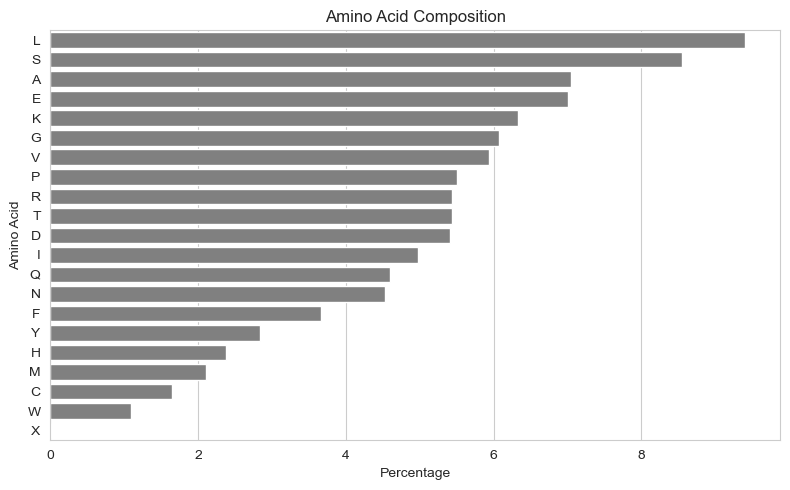

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns



aa_counts = {}

for seq in df['Sequences']:
    for aa in seq:
        if aa in aa_counts:
            aa_counts[aa] += 1
        else:
            aa_counts[aa] = 1

total_aa = sum(aa_counts.values())

aa_percentages = {aa: count/total_aa*100 for aa, count in aa_counts.items()}

sorted_aa_percentages = sorted(aa_percentages.items(), key=lambda x: x[1], reverse=True)

labels = [aa for aa, pct in sorted_aa_percentages]
percentages = [pct for aa, pct in sorted_aa_percentages]

sns.set_style("whitegrid")
sns.set_palette("dark")
#sns.color_palette(["#BBC7D3", "#6C7A89", "#2C3E50", "#1F2D3D", "#152639"])
#sns.color_palette("Blues_r", n_colors=5)

plt.figure(figsize=(8,5))
ax = sns.barplot(x=percentages, y=labels, color='grey')
ax.set_xlabel('Percentage')
ax.set_ylabel('Amino Acid')
ax.set_title('Amino Acid Composition')
plt.tight_layout()

plt.savefig('amino_acid_composition.png', dpi=500, bbox_inches='tight')

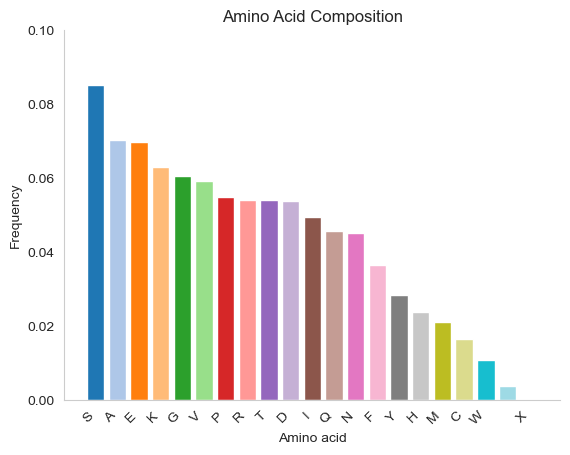

In [15]:
# Define color scheme
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
          '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
          '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
          '#17becf', '#9edae5']


aa_counts = df['Sequences'].str.split('').apply(pd.Series).stack().value_counts()
aa_freqs = aa_counts / aa_counts.sum()
x_labels = aa_freqs.index.values[1:]
fig, ax = plt.subplots()
ax.grid(False)
ax.bar(x_labels, aa_freqs[1:], color=colors)
ax.set_xlabel('Amino acid')
ax.set_ylabel('Frequency')
ax.set_title('Amino Acid Composition')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 0.1])
plt.xticks(rotation=45, ha='right')


plt.show()


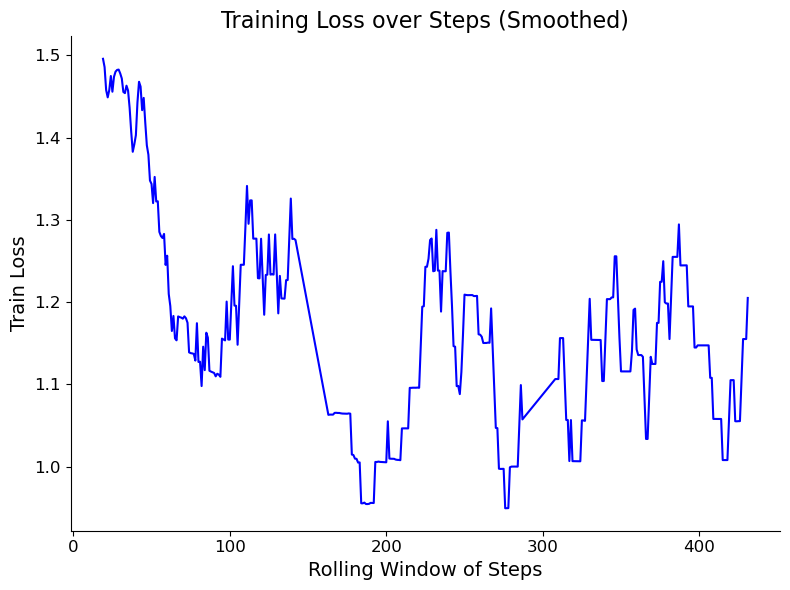

In [15]:
df = pd.read_csv('/Users/pierredemetz/UCL_work/COMP0082-CW/code/experiments/lightning_logs/22-02-2023--10-22-41/metrics.csv')
df['smoothed_train_loss'] = df['train_loss'].rolling(window=20).mean()

fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(x=df.index, y='smoothed_train_loss', data=df, color='blue', ax=ax)

ax.set_xlabel('Rolling Window of Steps', fontsize=14)
ax.set_ylabel('Train Loss', fontsize=14)
ax.set_title('Training Loss over Steps (Smoothed)', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=500, bbox_inches='tight')


## Finalisation the different datasets and exporting them as pickle files

In [17]:
def train_test_split(df, validation_set = False):  
    """
    This function splits the large df into subdatasets for training and testing
    """
    df = df.sample(frac=1)
    #train test split of dataset 
    train_size = 0.8
    train_df=df.sample(frac=train_size,random_state=200)
    test_df=df.drop(train_df.index).reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    
    if validation_set:
        #split the train further with a validation dataset
        train_size = 0.8
        train2_df = train_df.sample(frac=train_size, random_state=300)
        val_df = train_df.drop(train2_df.index).reset_index(drop=True)
        train2_df = train2_df.reset_index(drop=True)
    
        return train2_df, test_df, val_df
   
    return train_df, test_df

train_df, test_df, val_df = train_test_split(df, validation_set = True)

In [16]:
#transform the one hot encoded columns into floats
train_df[['cyto','mito','nucleus','other','secreted']]=train_df[['cyto','mito','nucleus','other','secreted']].astype('float')
test_df[['cyto','mito','nucleus','other','secreted']]=test_df[['cyto','mito','nucleus','other','secreted']].astype('float')
val_df[['cyto','mito','nucleus','other','secreted']]=val_df[['cyto','mito','nucleus','other','secreted']].astype('float')

NameError: name 'train_df' is not defined

In [21]:
#prepare the train, test, val datasets
train_df['Sequences'] = train_df['Sequences'].apply(lambda x: ' '.join(list(x)))
test_df['Sequences'] = test_df['Sequences'].apply(lambda x: ' '.join(list(x)))
val_df['Sequences'] = val_df['Sequences'].apply(lambda x: ' '.join(list(x)))

In [36]:
#prepare blind dataset 
df_blind[['cyto','mito','nucleus','other','secreted']]=float(0.0)

df_blind['Sequences'] = df_blind['Sequences'].apply(lambda x: ' '.join(list(x)))

df_blind =df_blind.drop(columns=['Label'])

In [43]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
val_df.to_pickle('val_df.pkl')
df_blind.to_pickle('blind_df.pkl')